In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import hess
import hess.utils as utils

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
use_cuda = torch.cuda.is_available()

In [4]:
model = Net()

saved_model = torch.load("./model.pt", map_location=('cpu'))
model.load_state_dict(saved_model)
if use_cuda:
    torch.cuda.set_device(4)
    model = model.cuda()

In [5]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/datasets/cifar10/', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/datasets/cifar10/', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
fpath = "./"
fname = "cifar_evecs_200.pt"

evecs = torch.load(fpath + fname, map_location=("cpu")).squeeze()

fpath = "./"
fname = "cifar_evals_200.pt"

evals = torch.load(fpath + fname, map_location=("cpu"))

In [7]:
keep = np.where(evals != 1)[0]
n_evals = keep.size
evals = evals[keep].numpy()
evecs = evecs[:, keep].numpy()

idx = np.abs(evals).argsort()[::-1]  
evals = torch.FloatTensor(evals[idx])
evecs = torch.FloatTensor(evecs[:, idx])

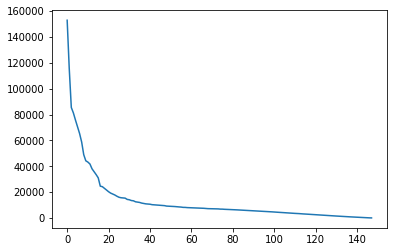

In [8]:
plt.plot(evals)

In [8]:
pars = utils.flatten(model.parameters())
n_par = pars.numel()
par_len = pars.norm()

In [9]:
def gram_schmidt(vector, basis):
    n_base = basis.shape[-1]
    for bb in range(n_base):
        vector = vector - vector.dot(basis[:, bb]).div(basis[:, bb].norm()) * basis[:, bb]
        vector = vector.div(vector.norm())
        
    return vector

## Get the Training Loss

In [10]:
criterion = nn.CrossEntropyLoss()

In [26]:
def compute_loss(model):
    train_loss = 0.
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print statistics
        train_loss += loss.item()        
        
    return train_loss

In [27]:
print("train loss = ", compute_loss(model))

train loss =  990.0996938049793


## Start Perturbing

In [28]:
par_len

tensor(41.0884, device='cuda:4', grad_fn=<NormBackward0>)

#### High Curvature Directions

In [25]:
n_scale = 10
scales = torch.linspace(0, 1., n_scale)
high_curve_losses = torch.zeros(n_scale)

for ii in range(n_scale):
    alpha = torch.randn(n_evals)
    pert = evecs.matmul(alpha.unsqueeze(-1)).t()
    pert = scales[ii] * pert.div(pert.norm())
    if use_cuda:
        pert = pert.cuda()
    pert = utils.unflatten_like(pert, model.parameters())

    
    for i, par in enumerate(model.parameters()):
        par.data = par.data + pert[i]
        
    high_curve_losses[ii] = compute_loss(model)
    print(high_curve_losses[ii])
    model.load_state_dict(saved_model)

tensor(7507.0767)
tensor(7608.7417)
tensor(7542.0396)
tensor(7690.3521)
tensor(8193.2861)
tensor(8591.6045)


KeyboardInterrupt: 

#### Low Curvature Directions

In [48]:
n_scale = 10
scales = torch.linspace(0, 1., n_scale)
low_curve_losses = torch.zeros(n_scale)

for ii in range(n_scale):
    alpha = torch.randn(n_par)
    pert = gram_schmidt(alpha, evecs).unsqueeze(-1).t()
    pert = scales[ii] * pert.div(pert.norm())
    if use_cuda:
        pert = pert.cuda()

    pert = utils.unflatten_like(pert, model.parameters())
    
    for i, par in enumerate(model.parameters()):
        par.data = par.data + pert[i]
        
    low_curve_losses[ii] = compute_loss(model)
    print(low_curve_losses[ii])
    model.load_state_dict(saved_model)

tensor(938.6365)
tensor(938.6570)
tensor(938.9398)


KeyboardInterrupt: 

### Number of Points Classified Differently

First need the class labels predicted by the trained model

In [11]:
model_preds = []
for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    if use_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()

    outputs = model(inputs)        
    _, predicted = torch.max(outputs, 1)
    
    model_preds.append(predicted.cpu())

In [16]:
n_scale = 10
scales = torch.linspace(0, 1., n_scale)
n_diff_high = torch.zeros(n_scale)

for ii in range(n_scale):
    alpha = torch.randn(n_evals)
    pert = evecs.matmul(alpha.unsqueeze(-1)).t()
    pert = scales[ii] * pert.div(pert.norm())
    if use_cuda:
        pert = pert.cuda()
    pert = utils.unflatten_like(pert, model.parameters())

    ## perturb ##
    for i, par in enumerate(model.parameters()):
        par.data = par.data + pert[i]
    
    ## generate predictions and record differences ##
    for dd, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)        
        _, predicted = torch.max(outputs, 1)

        n_diff_high[ii] += torch.sum(predicted.cpu() != model_preds[dd])
#         print(n_diff_high[ii])
        
    print(n_diff_high[ii])
    model.load_state_dict(saved_model)



tensor(1306.)
tensor(1607.)
tensor(3262.)
tensor(3856.)
tensor(6158.)
tensor(8052.)
tensor(7903.)
tensor(10033.)
tensor(11508.)
tensor(12359.)


In [20]:
n_scale = 10
scales = torch.linspace(0, 1., n_scale)
n_diff_low = torch.zeros(n_scale)

for ii in range(n_scale):
    alpha = torch.randn(n_par)
    pert = gram_schmidt(alpha, evecs).unsqueeze(-1).t()
    pert = scales[ii] * pert.div(pert.norm())
    if use_cuda:
        pert = pert.cuda()

    pert = utils.unflatten_like(pert, model.parameters())
    
    for i, par in enumerate(model.parameters()):
        par.data = par.data + pert[i]
        
    ## generate predictions and record differences ##
    for dd, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)        
        _, predicted = torch.max(outputs, 1)

        n_diff_low[ii] += torch.sum(predicted.cpu() != model_preds[dd])
    
    print(n_diff_low[ii])
    model.load_state_dict(saved_model)

tensor(0.)
tensor(103.)
tensor(179.)
tensor(321.)


KeyboardInterrupt: 

In [4]:
ii = 4
n_scale = 10
print("high curve scale {} of {} done".format(ii, n_scale))

high curve scale 4 of 10 done
